# Political News and the Fair Exposure Problem under Homophily

## All required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt
import re

import random
import platform_opt
from players import *

from IPython.display import Markdown, display, Latex
from scipy.stats import norm

def printmd(string):
    display(Markdown(string))

## Important Parameters

- $T$: Number of timesteps
- $M$: Finite mass of user
- $g \in \{A, B\}$: Political Affliation/ Preference
- $\pi_g \in (0, 1)$: Fraction of users from group $g$ 
- $t \in \{1, \cdots , T\}$:  Discrete Time T $\leq $ M
- $s \in \{a, b\}$: Article sources afliated with $A, B$
- $\theta_{A}, \theta_B \in [0, 1]$: Fraction of users shown an article
- $P_{g,s}$: Probability of users of group $g$ who like an article from source $s$
- $c > 0$: Cost user incur for clicking an article
- $v > 0$: Utility users get for liking an article
- $q_{g} > 0.5$: Probability of in-group propagation 

## Load and clean the dataset:  [Replication Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/AAI7VA)

### Dataset description borrowed from ReadMe.md of [Replication Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/AAI7VA)

#### Top500 

- domain ---> s: domain
- l1 ---> $P_{A}$ : proportion of shares with liberal alignment from s
- r1 ---> $P_{B}$: proportion of shares with conservative alignment from s

The top 500 most shared domains have each been shared at least 44,000 times. 
- T = ?
- |a| < |b|

This set of domains covers over 80% of the URLs classified as hard content that

#### Homophily

- viewer ---> A / B: affiliation of an individual in the sampling frame of the study.
- friend ---> A / B : affiliation of friend.
- frac_of_friends --->: bucketed (in increments of 0.01) fraction of friends with the given affiliation.
- density --->: proportion of friends within the given bucket.



## Load the dataset

In [2]:
# load the datasets
data_path = "../Datasets/ReplicationForExposure/"

homophily_data = pd.read_csv(data_path + "homophily_density", sep=",", header=0, quotechar='"', encoding="utf8",
                             names=['Group1', 'Group2', 'Frac_of_Friends', 'Density'])
top_500_data = pd.read_csv(data_path + "top500", sep=",", quotechar='"', encoding="utf8")

## Prevalence ($\pi_g$)

From the fine-grained dataset, we estimate that the values of $\pi$ are:

$\pi_A=0.49$
$\pi_B=0.51$

## Homophily parameters ($q_g$)

In [3]:
# Drop moderates from the homophily data
h = homophily_data.loc[~((homophily_data['Group1']=='Moderates') | (homophily_data['Group2']=='Moderate friends'))]

# replace Liberals with A
# replace conservatives with B
homophily = h.copy()
homophily['Group1'] = homophily['Group1'].replace(['Liberals'],'A')
homophily['Group1'] = homophily['Group1'].replace(['Conservatives'],'B')
homophily['Group2'] = homophily['Group2'].replace(['Liberal friends'],'A')
homophily['Group2'] = homophily['Group2'].replace(['Conservative friends'],'B')

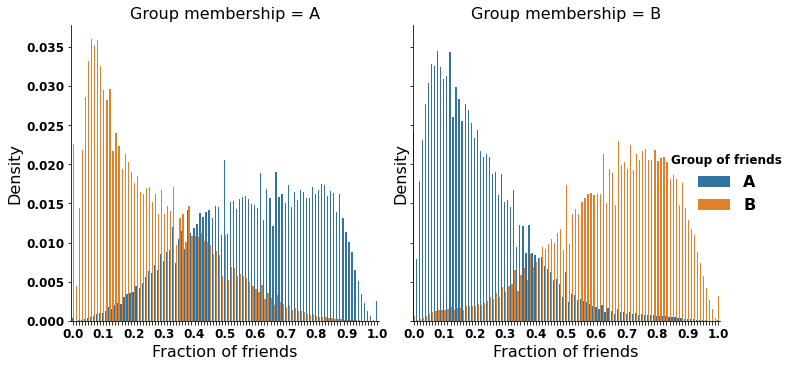

In [15]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
LARGE_SIZE = 16

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LARGE_SIZE)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

g = sns.catplot(data=homophily, kind='bar',
            x='Frac_of_Friends', y='Density',
            hue='Group2', col='Group1')

for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().replace('Group1', 'Group membership'))
    # reduce xtick density
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible(ind % 10 == 0)
        
g._legend.set_title('Group of friends')

g.set(xlabel='Fraction of friends', ylabel='Density')
g.savefig("dists.png", bbox_inches='tight', dpi=600)

In [95]:
# mean homophilies
AA = homophily.query('Group1=="A" & Group2=="A"')
AA_mean = (AA.Density * AA.Frac_of_Friends).sum()

AB = homophily.query('Group1=="A" & Group2=="B"')
AB_mean = (AB.Density * AB.Frac_of_Friends).sum()

# we take the average between the two means to
# make sure that q_A + (1-q_A) = 1
AA_AB_mean = (AA_mean + (1 - AB_mean)) / 2
AB_AA_mean = (AB_mean + (1 - AA_mean)) / 2
assert AA_AB_mean + AB_AA_mean == 1

BB = homophily.query('Group1=="B" & Group2=="B"')
BB_mean = (BB.Density * BB.Frac_of_Friends).sum()

BA = homophily.query('Group1=="B" & Group2=="A"')
BA_mean = (BA.Density * BA.Frac_of_Friends).sum()

BB_BA_mean = (BB_mean + (1 - BA_mean)) / 2
BA_BB_mean = (BA_mean + (1 - BB_mean)) / 2
assert BB_BA_mean + BA_BB_mean == 1

In [96]:
display(Latex("$\nq_A: {}$".format(AA_AB_mean)))
display(Latex("$1 - q_A: {}$".format(AB_AA_mean)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [97]:
display(Latex("\n$q_B: {}$".format(BB_BA_mean)))
display(Latex("$1 - q_B: {}$".format(BA_BB_mean)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Probability Distributions of sharing probs

In [105]:
# remove very liberal, moderates, and very conservatives from top500 data
domains = top_500_data.drop(['l2', 'n', 'r2'], axis=1)

# replace liberal with A and conservative with B
domains.columns = ['s', 'avg_align', 'P_A', 'P_B']

## Determine source affliation based on the av_align
domains.loc[domains['avg_align'] < 0, 's'] = 'a'
domains['s'].mask(domains['s'] != 'a', 'b', inplace=True)
domains = domains.drop(['avg_align'], axis=1)
domains.sample(frac=1).reset_index(drop=True)
domains.head()

,s,P_A,P_B
0,a,0.1755,0.0002
1,a,0.8480,0.0000
2,a,0.0945,0.0001
3,a,0.0072,0.0000
4,a,0.0473,0.0000


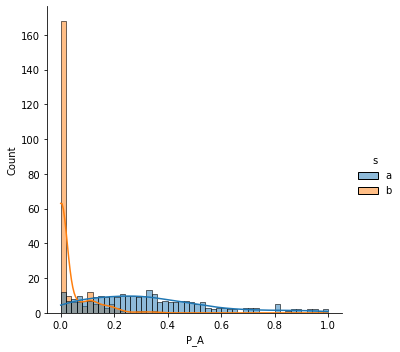

In [121]:
sns.displot(x='P_A', hue='s', data=domains, bins=50, kde=True)

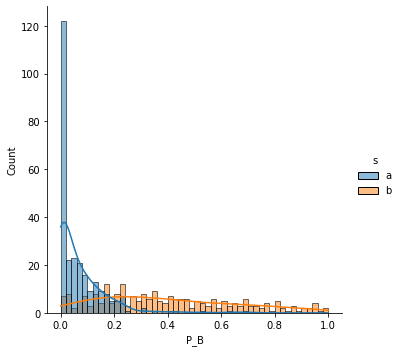

In [122]:
sns.displot(x='P_B', hue='s', data=domains, bins=50, kde=True)

### Change probabilities from 0 to 0.0000000001 and 1 to 0.99998

### Fitting the probability distributions

In [124]:
domains.loc[domains['P_A'] == 0, 'P_A'] = 0.0000000001
domains.loc[domains['P_B'] == 0, 'P_B'] = 0.0000000001
domains.loc[domains['P_A'] == 1, 'P_A'] = 0.99998
domains.loc[domains['P_B'] == 1, 'P_B'] = 0.99998

#### Probabilities of $P_{A}$

0.15055381108177784 0.7738574425709343


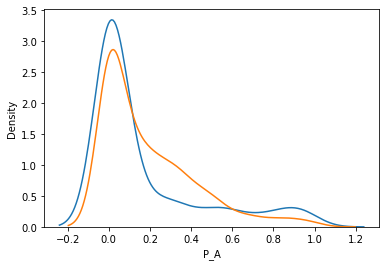

In [125]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(domains.P_A, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains.P_A.shape[0]))
sns.kdeplot(domains.P_A)

#### Probabilities of $P_{B}$

0.15055381108177784 0.7738574425709343


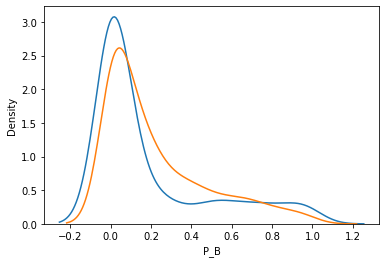

In [126]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a2, b2, loc2, scale2 = beta.fit(domains.P_B, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains.P_B.shape[0]))
sns.kdeplot(domains.P_B)

#### Probabilities of $P_{A, a}$

0.8828729918440646 1.6247070146941363


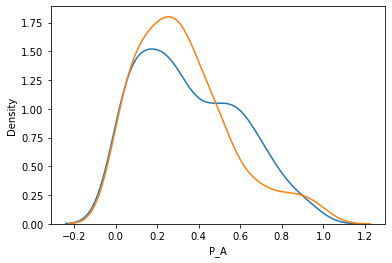

In [127]:
# MLE estimates for the parameters of the beta distribution (for p_A)
domains_aa = domains[domains.s=='a']
a1, b1, loc1, scale1 = beta.fit(domains_aa.P_A, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains_aa.P_A.shape[0]))
sns.kdeplot(domains_aa.P_A)

#### Probabilities of $P_{A, b}$

0.09576097403924465 3.09136619146736


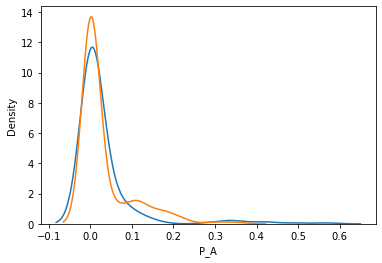

In [128]:
# MLE estimates for the parameters of the beta distribution (for p_A)
domains_ab = domains[domains.s=='b']
a1, b1, loc1, scale1 = beta.fit(domains_ab.P_A, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains_ab.P_A.shape[0]))
sns.kdeplot(domains_ab.P_A)

#### Probabilities of $P_{B,a}$

0.1822515775580026 2.7574965182522644


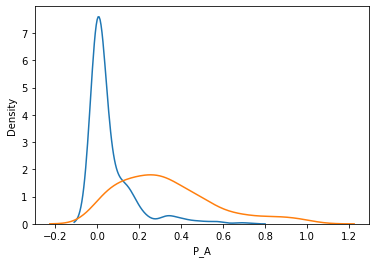

In [129]:
# MLE estimates for the parameters of the beta distribution (for p_A)
domains_ba = domains[domains.s=='a']
a1, b1, loc1, scale1 = beta.fit(domains_ba.P_B, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains_ba.P_A.shape[0]))
sns.kdeplot(domains_ba.P_A)

#### Probabilities of $P_{B,b}$

0.9541492709534125 1.345006644515015


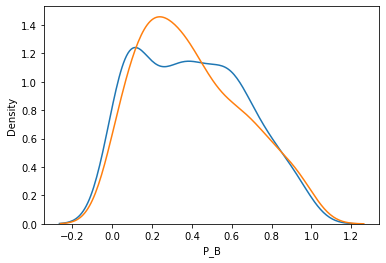

In [130]:
# MLE estimates for the parameters of the beta distribution (for p_A)
domains_bb = domains[domains.s=='b']
a1, b1, loc1, scale1 = beta.fit(domains_bb.P_B, floc=0, fscale=1)
print(a1, b1)
sns.kdeplot(np.random.beta(a=a1, b=b1, size=domains_bb.P_B.shape[0]))
sns.kdeplot(domains_bb.P_B)